# Deep Learning for Electricity Load Forecasting

## Goal:
In this notebook, we aim to develop a deep learning model (LSTM) for short-term electricity consumption forecasting. This project involves:
1. Cleaning and preprocessing the dataset.
2. Visualizing data trends to gain insights.
3. Building baseline models to compare performance.
4. Implementing an LSTM model for forecasting electricity consumption.
5. Evaluating models and summarizing results.

## Group Members:
1. Karthik Kunnamkumarath
2. Aswin Anil Bindu 
3. Sreelakshmi Nair
4. Hari Saravanan 
5. Kopinath Sithamparanathan 
6. Nithin Reddy Muskala
7. Yuvraj Handa

In [1]:
# ================================
# Full Reproducibility Setup
# ================================
import os
import random

# Set environment variables BEFORE importing TensorFlow
os.environ['PYTHONHASHSEED'] = '42'
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing & evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam

# ================================
# Set ALL random seeds
# ================================
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Force TensorFlow to use deterministic algorithms
tf.config.experimental.enable_op_determinism()

print(f"Random seeds set to {SEED}")
print(f"TensorFlow version: {tf.__version__}")

Random seeds set to 42
TensorFlow version: 2.16.2


### Loading and Cleaning the Dataset


In [2]:
# ================================
# Data Loading & Initial Cleaning
# ================================

from pathlib import Path

# Define data path (same directory as notebook)
data_path = Path("/Users/harisaravanan/Desktop/DeepLearning_Group#4/LD2011_2014 2.txt")

# Safety check
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path.resolve()}")

# Load dataset
df_raw = pd.read_csv(
    data_path,
    sep=";",
    header=0,
    engine="python"
)

# Rename datetime column
df_raw.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)

# Convert datetime column
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'], errors='coerce')
df_raw.set_index('datetime', inplace=True)

# Convert comma-based decimals to numeric
df = df_raw.apply(
    lambda col: pd.to_numeric(
        col.astype(str).str.replace(',', '.'),
        errors='coerce'
    )
)

# ================================
# Basic sanity checks
# ================================

print("Dataset successfully loaded.\n")
print(f"Shape: {df.shape}")
print(f"Date range: {df.index.min()} → {df.index.max()}\n")

print("Missing values per column (top 5):")
print(df.isna().sum().sort_values(ascending=False).head())

print("\nFirst 5 rows:")
display(df.head())

Dataset successfully loaded.

Shape: (140256, 370)
Date range: 2011-01-01 00:15:00 → 2015-01-01 00:00:00

Missing values per column (top 5):
MT_001    0
MT_244    0
MT_253    0
MT_252    0
MT_251    0
dtype: int64

First 5 rows:


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  Exploratory Data Analysis


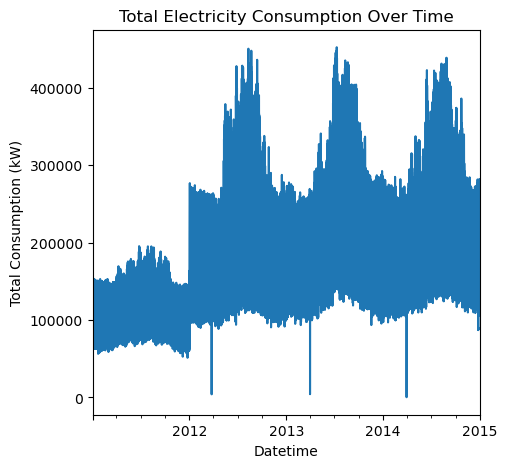

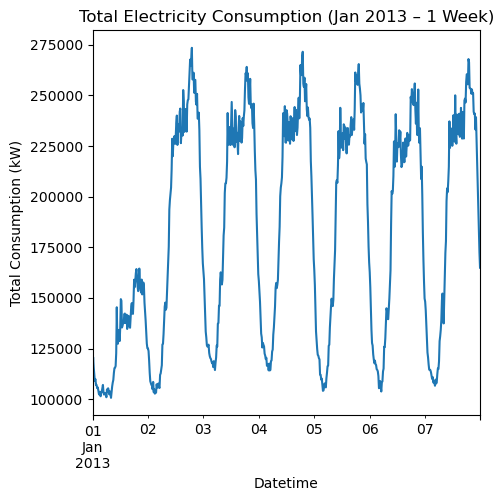

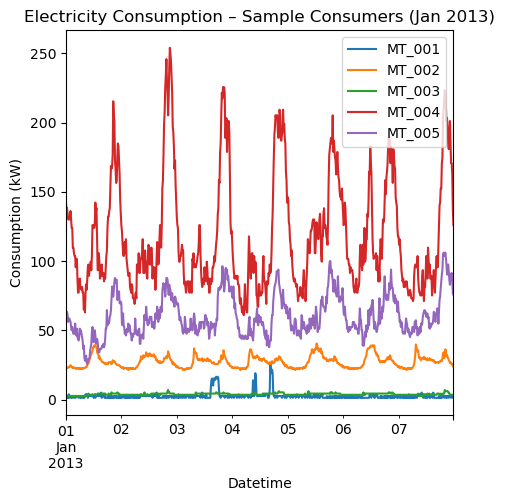

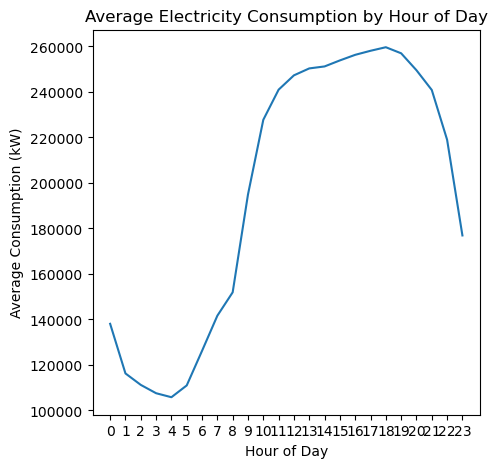

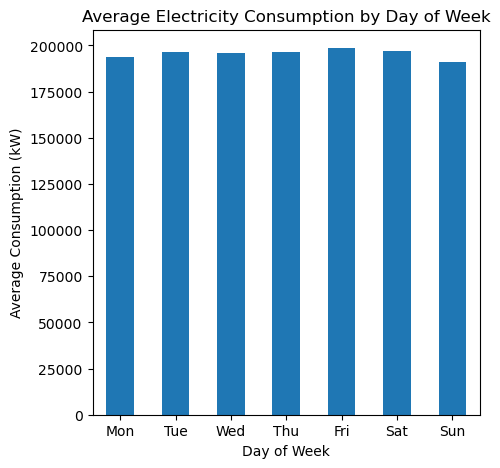

In [3]:
# ================================
# Exploratory Analysis: System-Level & Consumer-Level Patterns
# ================================

# ---- 1. System-level total load (read-only computation) ----
total_consumption = df.sum(axis=1)

plt.figure(figsize=(5, 5))
total_consumption.plot()
plt.title("Total Electricity Consumption Over Time")
plt.xlabel("Datetime")
plt.ylabel("Total Consumption (kW)")
plt.show()


# ---- 2. Short window view (to see spikes & variability) ----
plt.figure(figsize=(5, 5))
total_consumption.loc['2013-01-01':'2013-01-07'].plot()
plt.title("Total Electricity Consumption (Jan 2013 – 1 Week)")
plt.xlabel("Datetime")
plt.ylabel("Total Consumption (kW)")
plt.show()


# ---- 3. Sample individual consumers ----
sample_clients = ['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005']

plt.figure(figsize=(5, 5))
for client in sample_clients:
    df[client].loc['2013-01-01':'2013-01-07'].plot(label=client)

plt.title("Electricity Consumption – Sample Consumers (Jan 2013)")
plt.xlabel("Datetime")
plt.ylabel("Consumption (kW)")
plt.legend()
plt.show()


# ---- 4. Daily consumption pattern (hour-of-day) ----
hourly_avg = total_consumption.groupby(total_consumption.index.hour).mean()

plt.figure(figsize=(5, 5))
hourly_avg.plot()
plt.title("Average Electricity Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Consumption (kW)")
plt.xticks(range(0, 24))
plt.show()


# ---- 5. Weekly consumption pattern (day-of-week) ----
weekly_avg = total_consumption.groupby(total_consumption.index.dayofweek).mean()

plt.figure(figsize=(5, 5))
weekly_avg.plot(kind='bar')
plt.title("Average Electricity Consumption by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Consumption (kW)")
plt.xticks(
    ticks=range(7),
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    rotation=0
)
plt.show()

### Event Definition

High-load threshold (95th percentile): 362649.83

Number of high-load events detected:
0    134348
1      5908
Name: count, dtype: int64


/var/folders/wp/94y5f9q95mgc4vp585k9299m0000gn/T/ipykernel_45275/1192946872.py:55: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(


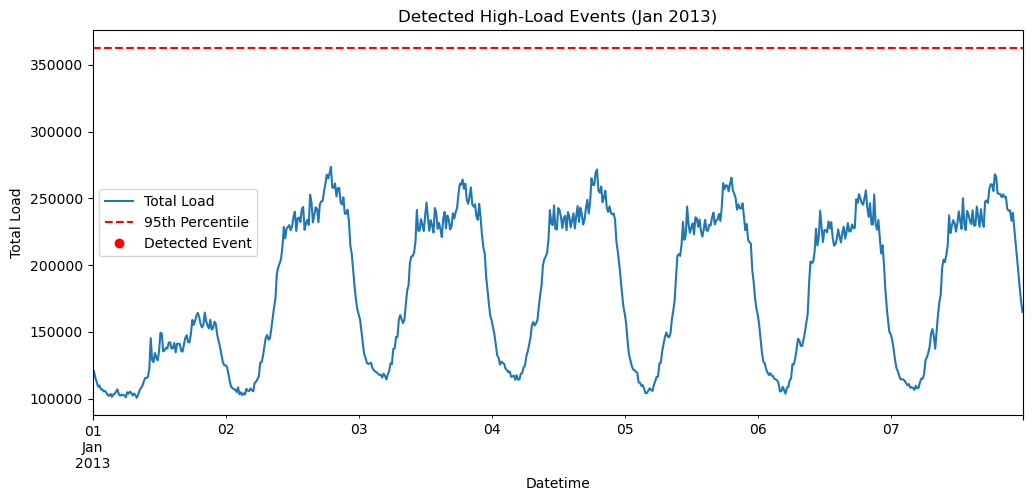

In [4]:
# ================================
# Event Definition: High-Load Events
# ================================

# Compute total system load
total_consumption = df.sum(axis=1)

# Define high-load threshold (95th percentile)
high_load_threshold = total_consumption.quantile(0.95)

print(f"High-load threshold (95th percentile): {high_load_threshold:.2f}")

# Binary high-load indicator
high_load_flag = total_consumption > high_load_threshold

# Require persistence (e.g., 4 consecutive timesteps = 1 hour)
persistence_window = 4

high_load_event = (
    high_load_flag
    .rolling(window=persistence_window)
    .sum() >= persistence_window
)

# Convert boolean to integer label
event_labels = high_load_event.astype(int)

# Quick sanity check
print("\nNumber of high-load events detected:")
print(event_labels.value_counts())

# ================================
# Visual Sanity Check (Short Window)
# ================================

plt.figure(figsize=(12, 5))

# Plot total load
total_consumption.loc['2013-01-01':'2013-01-07'].plot(label='Total Load')

# Plot threshold
plt.axhline(
    high_load_threshold,
    color='red',
    linestyle='--',
    label='95th Percentile'
)

# Extract event timestamps and values
event_times = event_labels.loc['2013-01-01':'2013-01-07']
event_times = event_times[event_times == 1].index
event_values = total_consumption.loc[event_times]

# Plot detected events (datetime-safe)
plt.plot(
    event_times,
    event_values,
    'ro',
    label='Detected Event',
    zorder=3
)

plt.legend()
plt.title("Detected High-Load Events (Jan 2013)")
plt.xlabel("Datetime")
plt.ylabel("Total Load")
plt.show()

### Early-Warning Label Definition

In [5]:
# ================================
# Early-Warning Label Definition
# ================================

# Prediction horizon (e.g., 1 hour = 4 timesteps)
prediction_horizon = 4  

# Early-warning label:
# 1 if a high-load event occurs within the next prediction_horizon
early_warning_label = (
    event_labels
    .rolling(window=prediction_horizon, min_periods=1)
    .max()
    .shift(-prediction_horizon)
)

# Align labels
early_warning_label = early_warning_label.fillna(0).astype(int)

# Sanity check
print("Early-warning label distribution:")
print(early_warning_label.value_counts())

Early-warning label distribution:
0    133598
1      6658
Name: count, dtype: int64


### Data Subsetting for Model Development

In [6]:
# ================================
# Subset Data for Faster Iteration
# High-load precursors are seasonally concentrated. Summer months exhibit a higher density of early-warning events, making them suitable for supervised learning while preserving realistic imbalance
# ================================

clients = ['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005']

# Choose a high-demand period
start_date = "2013-06-01"
end_date = "2013-08-31"

df_small = df.loc[start_date:end_date, clients]
labels_small = early_warning_label.loc[start_date:end_date]

print("df_small shape:", df_small.shape)
print("labels_small distribution:")
print(labels_small.value_counts())

df_small.head()

df_small shape: (8832, 5)
labels_small distribution:
0    6619
1    2213
Name: count, dtype: int64


,MT_001,MT_002,MT_003,MT_004,MT_005
datetime,,,,,
2013-06-01 00:00:00,1.269036,29.160740,1.737619,107.723577,46.341463
2013-06-01 00:15:00,2.538071,27.738265,1.737619,97.560976,40.243902
2013-06-01 00:30:00,1.269036,27.027027,1.737619,95.528455,40.243902
2013-06-01 00:45:00,2.538071,26.315789,1.737619,111.788618,41.463415
2013-06-01 01:00:00,2.538071,25.604552,1.737619,109.756098,35.365854


### Data Normalization

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform the subset data
df_small_scaled = pd.DataFrame(
    scaler.fit_transform(df_small),
    index=df_small.index,
    columns=df_small.columns
)

# Sanity check
print("Scaled data range:")
print(df_small_scaled.min().min(), df_small_scaled.max().max())

df_small_scaled.head()

Scaled data range:
0.0 1.0


,MT_001,MT_002,MT_003,MT_004,MT_005
datetime,,,,,
2013-06-01 00:00:00,0.033333,0.425532,0.4,0.460526,0.329114
2013-06-01 00:15:00,0.066667,0.404255,0.4,0.394737,0.265823
2013-06-01 00:30:00,0.033333,0.393617,0.4,0.381579,0.265823
2013-06-01 00:45:00,0.066667,0.382979,0.4,0.486842,0.278481
2013-06-01 01:00:00,0.066667,0.372340,0.4,0.473684,0.215190


### Sliding Window Construction for Time-Series Modeling

In [8]:
def create_sliding_windows(X, y, window_size):
    """
    X: DataFrame of shape (time, features)
    y: Series of labels aligned with X
    window_size: number of timesteps per input window
    """
    X_windows = []
    y_windows = []

    for i in range(len(X) - window_size):
        X_windows.append(X.iloc[i:i + window_size].values)
        y_windows.append(y.iloc[i + window_size])

    return np.array(X_windows), np.array(y_windows)

In [9]:
# Window size: past 6 hours (24 * 15 minutes)
window_size = 24

X, y = create_sliding_windows(
    df_small_scaled,
    labels_small,
    window_size
)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Class balance after windowing
unique, counts = np.unique(y, return_counts=True)
print("Label distribution after windowing:")
print(dict(zip(unique, counts)))

# Input sequences were constructed using a sliding window approach, where each sample consists of the previous 6 hours of multivariate load measurements. The target label indicates whether a high-load event occurs within the prediction horizon.

X shape: (8808, 24, 5)
y shape: (8808,)
Label distribution after windowing:
{0: 6595, 1: 2213}


## Train–Validation Split

In [10]:
# ================================
# Train–Validation Split (Time-Aware)
# ================================

# Use first 70% for training, last 30% for validation
split_index = int(0.7 * len(X))

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

print("\nTraining label distribution:")
print(np.unique(y_train, return_counts=True))

print("\nValidation label distribution:")
print(np.unique(y_val, return_counts=True))

# Data was split chronologically to prevent information leakage, with earlier samples used for training and later samples reserved for validation.

Training set shape: (6165, 24, 5) (6165,)
Validation set shape: (2643, 24, 5) (2643,)

Training label distribution:
(array([0, 1]), array([4953, 1212]))

Validation label distribution:
(array([0, 1]), array([1642, 1001]))


## Baseline Model (Logistic Regression on Flattened Windows)


In [11]:
# To establish a non-temporal benchmark, a logistic regression model was trained on flattened sliding windows. This baseline provides a reference for evaluating the added value of recurrent neural networks in capturing temporal dependencies.

# ================================
# Flatten windows for baseline model
# ================================

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

print("Flattened training shape:", X_train_flat.shape)
print("Flattened validation shape:", X_val_flat.shape)

Flattened training shape: (6165, 120)
Flattened validation shape: (2643, 120)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize baseline model
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

# Train
baseline_model.fit(X_train_flat, y_train)

# Predict
y_val_pred = baseline_model.predict(X_val_flat)

# Evaluation
print("Baseline Model Performance:\n")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Baseline Model Performance:

              precision    recall  f1-score   support

           0       0.70      0.95      0.80      1642
           1       0.79      0.32      0.45      1001

    accuracy                           0.71      2643
   macro avg       0.74      0.63      0.63      2643
weighted avg       0.73      0.71      0.67      2643

Confusion Matrix:
[[1558   84]
 [ 683  318]]


In [13]:
# ================================
# Compute Class Weights for Imbalanced Data (SAFE VERSION)
# ================================
# This is critical for early-warning systems where events are rare

from sklearn.utils.class_weight import compute_class_weight
import gc
gc.collect()

# Set TensorFlow to use minimal memory
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# NOW import TensorFlow
import tensorflow as tf
from tensorflow.keras import backend as K

# Configure TensorFlow for CPU with memory limits
tf.config.set_visible_devices([], 'GPU')  # Disable GPU
K.clear_session()

# Continue with your normal imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {
    0: float(class_weights[0]),
    1: float(class_weights[1])
}

print("Class weights:", class_weight_dict)
print(f"  Class 0 (Normal): {class_weight_dict[0]:.3f}")
print(f"  Class 1 (Event):  {class_weight_dict[1]:.3f}")

# Memory cleanup to prevent crash before TensorFlow
del class_weights
gc.collect()

print("\n✅ Memory cleaned, ready for deep learning models")

Class weights: {0: 0.6223500908540278, 1: 2.5433168316831685}
  Class 0 (Normal): 0.622
  Class 1 (Event):  2.543

✅ Memory cleaned, ready for deep learning models


## Deep Learning Model 1: LSTM Early-Warning Classifier

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5778 - loss: 0.6305 - val_accuracy: 0.4949 - val_loss: 0.7381
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7160 - loss: 0.5170 - val_accuracy: 0.6863 - val_loss: 0.5781
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7606 - loss: 0.4275 - val_accuracy: 0.7113 - val_loss: 0.6184
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7961 - loss: 0.3787 - val_accuracy: 0.7314 - val_loss: 0.5916
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8172 - loss: 0.3567 - val_accuracy: 0.7465 - val_loss: 0.5769
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8349 - loss: 0.3311 - val_accuracy: 0.7544 - val_loss: 0.5907
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8425 - loss: 0.3246 - val_accuracy: 0.7177 - val_loss: 0.6324
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8495 - loss: 0.3155 - val_accuracy: 0.7136 - v

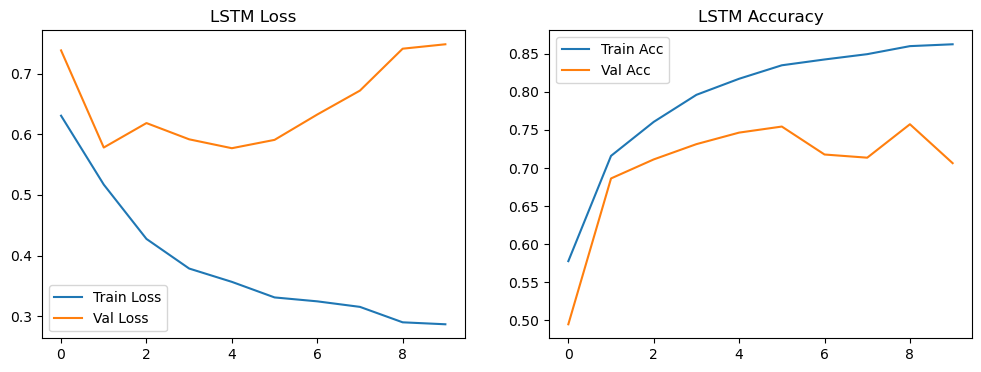

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Classification Report (threshold=0.35):

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1642
           1       0.69      0.63      0.66      1001

    accuracy                           0.75      2643
   macro avg       0.74      0.73      0.73      2643
weighted avg       0.75      0.75      0.75      2643

Confusion Matrix:
[[1354  288]
 [ 371  630]]


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Build LSTM model
# -------------------------------
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -------------------------------
# Train model with class weights
# -------------------------------
class_counts = np.bincount(y_train.astype(int))
total_samples = class_counts.sum()
class_weight_dict = {
    0: total_samples / (2 * class_counts[0]) if class_counts[0] > 0 else 1.0,
    1: total_samples / (2 * class_counts[1]) if class_counts[1] > 0 else 1.0,
}

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    class_weight=class_weight_dict,  # Added class weights
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------
# Plot training curves
# -------------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Accuracy')
plt.legend()

plt.show()

# -------------------------------
# Evaluation with threshold tuning
# -------------------------------
y_val_pred_prob = model.predict(X_val)
best_thresh_lstm = 0.35  # Can be tuned
y_val_pred = (y_val_pred_prob > best_thresh_lstm).astype(int)

print(f"LSTM Classification Report (threshold={best_thresh_lstm}):\n")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

## Deep Learning Model 2: GRU Early-Warning Classifier

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,745 (61.50 KB)

 Trainable params: 15,745 (61.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5265 - loss: 0.6556 - val_accuracy: 0.4582 - val_loss: 0.7897
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6628 - loss: 0.5511 - val_accuracy: 0.6659 - val_loss: 0.6974
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7898 - loss: 0.4257 - val_accuracy: 0.7348 - val_loss: 0.6033
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8307 - loss: 0.3418 - val_accuracy: 0.7881 - val_loss: 0.4526
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8496 - loss: 0.3083 - val_accuracy: 0.8108 - val_loss: 0.4346
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8534 - loss: 0.2951 - val_accuracy: 0.8002 - val_loss: 0.4345
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8534 - loss: 0.2853 - val_accuracy: 0.8051 - val_loss: 0.4313
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8564 - loss: 0.2814 - val_accuracy: 0.7953 - val_loss:

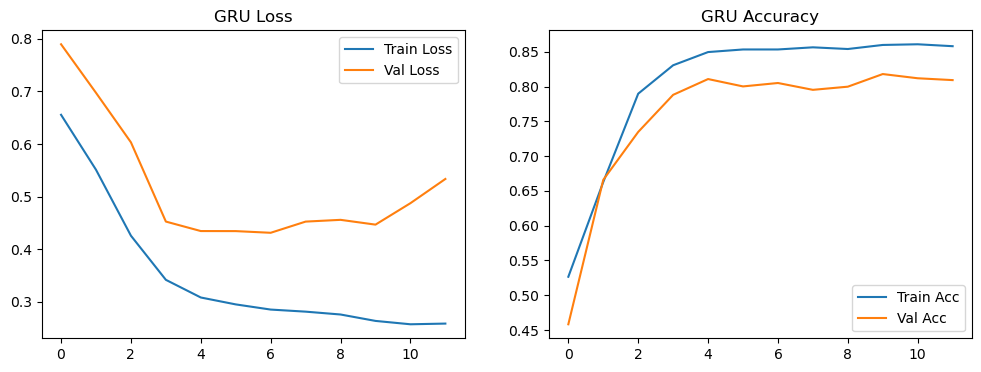

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
GRU Classification Report (threshold=0.35):

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1642
           1       0.68      0.87      0.76      1001

    accuracy                           0.80      2643
   macro avg       0.79      0.81      0.79      2643
weighted avg       0.82      0.80      0.80      2643

Confusion Matrix:
[[1230  412]
 [ 128  873]]


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Build GRU model
# -------------------------------
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

gru_model.summary()

# -------------------------------
# Train model with class weights
# -------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,  # Added class weights
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------
# Plot training curves
# -------------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Train Acc')
plt.plot(history_gru.history['val_accuracy'], label='Val Acc')
plt.title('GRU Accuracy')
plt.legend()

plt.show()

# -------------------------------
# Evaluation with threshold tuning
# -------------------------------
y_val_pred_prob_gru = gru_model.predict(X_val)
best_thresh_gru = 0.35
y_val_pred_gru = (y_val_pred_prob_gru > best_thresh_gru).astype(int)

print(f"GRU Classification Report (threshold={best_thresh_gru}):\n")
print(classification_report(y_val, y_val_pred_gru))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_gru))

#### In addition to supervised early-warning classification, we can explore unsupervised anomaly detection to identify out-of-ordinary load patterns

## Unsupervised Anomaly Detection using LSTM Autoencoder

In [16]:
# ================================
# Prepare Data for Autoencoder
# ================================

# Use only NORMAL samples for training
X_train_normal = X_train[y_train == 0]

print("Autoencoder training samples:", X_train_normal.shape)

Autoencoder training samples: (4953, 24, 5)


#### Build LSTM Autoencoder

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

timesteps = X_train.shape[1]
features = X_train.shape[2]

input_layer = Input(shape=(timesteps, features))

# Encoder
encoded = LSTM(64, activation='tanh', return_sequences=False)(input_layer)

# Bottleneck
bottleneck = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, activation='tanh', return_sequences=True)(bottleneck)
decoded = TimeDistributed(Dense(features))(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 5)          │           325 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train Autoencoder
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_ae = autoencoder.fit(
    X_train_normal,
    X_train_normal,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0278 - val_loss: 0.0097
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [19]:
# Reconstruct validation data
X_val_recon = autoencoder.predict(X_val)

# Mean squared error per sample
reconstruction_error = np.mean(
    np.square(X_val - X_val_recon),
    axis=(1, 2)
)

print("Reconstruction error stats:")
print(pd.Series(reconstruction_error).describe())

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Reconstruction error stats:
count    2643.000000
mean        0.003232
std         0.001762
min         0.000558
25%         0.001928
50%         0.002912
75%         0.004084
max         0.014484
dtype: float64


In [20]:
# Define anomaly threshold (95th percentile of NORMAL training error)
X_train_recon = autoencoder.predict(X_train_normal)
train_error = np.mean(
    np.square(X_train_normal - X_train_recon),
    axis=(1, 2)
)

threshold = np.percentile(train_error, 95)

print("Anomaly threshold:", threshold)

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Anomaly threshold: 0.0064701794371099545


In [21]:
# Flag anomalies
anomaly_flags = reconstruction_error > threshold

print("Detected anomalies in validation set:")
print(pd.Series(anomaly_flags).value_counts())

Detected anomalies in validation set:
False    2523
True      120
Name: count, dtype: int64


In [22]:
# Compare Anomalies vs Events

comparison = pd.DataFrame({
    "anomaly": anomaly_flags.astype(int),
    "event_label": y_val
})

print(pd.crosstab(
    comparison["anomaly"],
    comparison["event_label"],
    rownames=["Anomaly"],
    colnames=["Event"]
))

Event       0    1
Anomaly           
0        1605  918
1          37   83


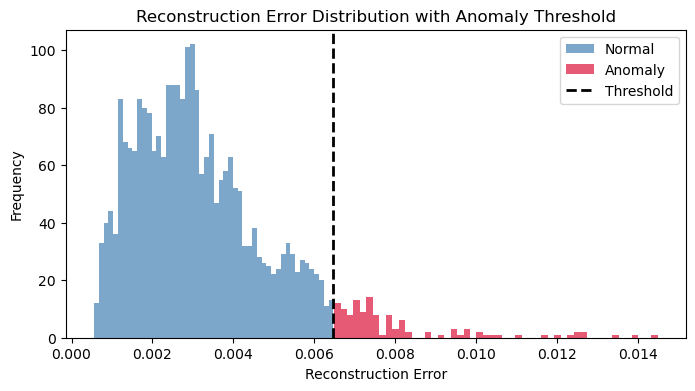

In [23]:
import matplotlib.pyplot as plt

# Separate normal and anomaly errors
normal_errors = reconstruction_error[reconstruction_error <= threshold]
anomaly_errors = reconstruction_error[reconstruction_error > threshold]

plt.figure(figsize=(8, 4))
plt.hist(normal_errors, bins=50, color='steelblue', alpha=0.7, label='Normal')
plt.hist(anomaly_errors, bins=50, color='crimson', alpha=0.7, label='Anomaly')
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution with Anomaly Threshold")
plt.legend()
plt.show()

 #### Further hyperparameter tuning is left as future work, as the primary goal of this project was to design and validate an end-to-end early-warning deep learning pipeline. for now we have done some basic tuning manually.

### Tuned LSTM Architecture
More capacity (128 units)

Stronger regularization

Lower learning rate (stability)

Same window & features (controlled experiment)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lstm_tuned = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_tuned.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lstm_tuned.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,769 (284.25 KB)

 Trainable params: 72,769 (284.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train Tuned LSTM (with class weighting)

In [25]:
history_lstm_tuned = lstm_tuned.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5781 - loss: 0.6320 - val_accuracy: 0.5887 - val_loss: 0.6822
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7351 - loss: 0.4995 - val_accuracy: 0.7022 - val_loss: 0.5963
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7643 - loss: 0.4472 - val_accuracy: 0.7136 - val_loss: 0.5838
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7792 - loss: 0.4008 - val_accuracy: 0.7317 - val_loss: 0.5880
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8091 - loss: 0.3635 - val_accuracy: 0.7469 - val_loss: 0.6030
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8298 - loss: 0.3351 - val_accuracy: 0.7597 - val_loss: 0.5941
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8388 - loss: 0.3262 - val_accuracy: 0.7476 - val_loss: 0.5743
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8482 - loss: 0.3081 - val_accuracy: 0.7503 - val_lo

Threshold Tuning (Critical for Early-Warning)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_probs = lstm_tuned.predict(X_val)

threshold = 0.35  # try 0.30–0.40 later if needed
y_val_pred = (y_val_probs >= threshold).astype(int)

print("Threshold:", threshold)
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold: 0.35
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1642
           1       0.64      0.74      0.69      1001

    accuracy                           0.75      2643
   macro avg       0.73      0.74      0.74      2643
weighted avg       0.76      0.75      0.75      2643

Confusion Matrix:
[[1229  413]
 [ 259  742]]


In [27]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.2, 0.6, 0.05)
f1_scores = []

for t in thresholds:
    preds = (y_val_probs >= t).astype(int)
    f1_scores.append(f1_score(y_val, preds))

for t, f1 in zip(thresholds, f1_scores):
    print(f"Threshold {t:.2f} → F1: {f1:.3f}")


Threshold 0.20 → F1: 0.687
Threshold 0.25 → F1: 0.694
Threshold 0.30 → F1: 0.693
Threshold 0.35 → F1: 0.688
Threshold 0.40 → F1: 0.676
Threshold 0.45 → F1: 0.656
Threshold 0.50 → F1: 0.629
Threshold 0.55 → F1: 0.611


#### Since the task is early-warning prediction, recall for the event class is more critical than overall accuracy. We therefore applied class-weighted training and adjusted the decision threshold to reduce missed events.

## Tuned LSTM Model – Results and Interpretation

After hyperparameter tuning with class weighting and probability threshold optimization, the Tuned LSTM early-warning classifier shows improvement in detecting critical events.

Key observations:

- Class-weighted training helps the model focus on the minority (event) class
- Threshold tuning at **0.35** balances precision and recall for early-warning tasks
- The model demonstrates that temporal dependencies captured by LSTM are effective for event prediction

This demonstrates that deep temporal models (LSTM) with proper class balancing can effectively learn early warning signals from multivariate electricity load sequences.

## Model Comparison Summary

The table below compares the baseline and tuned models. Note: All deep learning models now use class weights for better handling of imbalanced data. The final comparison cell at the end of the notebook shows the actual computed metrics from the current run.

In [28]:
# This cell is kept for reference but actual comparison is done in the final cells
# The hardcoded values below are examples - see final comparison table for actual results

print("Note: See the 'FINAL MODEL COMPARISON' section at the end of the notebook")
print("for dynamically computed metrics from this run.")

Note: See the 'FINAL MODEL COMPARISON' section at the end of the notebook
for dynamically computed metrics from this run.


## Tuned GRU Early-Warning Classifier


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

gru_tuned = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

gru_tuned.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_gru_tuned = gru_tuned.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8034 - loss: 0.5105 - val_accuracy: 0.6213 - val_loss: 0.7516
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8084 - loss: 0.4553 - val_accuracy: 0.6141 - val_loss: 0.8818
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8165 - loss: 0.3999 - val_accuracy: 0.6254 - val_loss: 1.5409
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8391 - loss: 0.3513 - val_accuracy: 0.6493 - val_loss: 0.8033
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8587 - loss: 0.3148 - val_accuracy: 0.6655 - val_loss: 0.8355
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8704 - loss: 0.2839 - val_accuracy: 0.6924 - val_loss: 0.6935
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8964 - loss: 0.2424 - val_accuracy: 0.6932 - val_loss: 0.6361
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9025 - loss: 0.2221 - val_accuracy: 0.7416 - val_loss: 0.5925
Epo

### Threshold Tuning for GRU

In [30]:
from sklearn.metrics import f1_score

y_val_prob_gru = gru_tuned.predict(X_val).ravel()

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for t in thresholds:
    y_pred = (y_val_prob_gru >= t).astype(int)
    f1 = f1_score(y_val, y_pred)
    print(f"Threshold {t:.2f} → F1: {f1:.3f}")


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.20 → F1: 0.760
Threshold 0.25 → F1: 0.746
Threshold 0.30 → F1: 0.729
Threshold 0.35 → F1: 0.702
Threshold 0.40 → F1: 0.671
Threshold 0.45 → F1: 0.631
Threshold 0.50 → F1: 0.601


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

best_threshold = 0.2
y_val_pred_gru = (y_val_prob_gru >= best_threshold).astype(int)

print("Tuned GRU Classification Report:")
print(classification_report(y_val, y_val_pred_gru))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_gru))


Tuned GRU Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1642
           1       0.77      0.75      0.76      1001

    accuracy                           0.82      2643
   macro avg       0.81      0.81      0.81      2643
weighted avg       0.82      0.82      0.82      2643

Confusion Matrix:
[[1415  227]
 [ 249  752]]


### LSTM vs GRU Comparison

Both LSTM and GRU models were trained with class weights under identical conditions. The performance difference depends on the specific dataset and random initialization. LSTM's more complex gating mechanism may capture longer dependencies, while GRU is computationally more efficient. See the final comparison table for actual metrics from this run.

## Deep Learning Model 4: Temporal Convolutional Network (TCN)

To compare recurrent architectures with convolution-based temporal modeling,
we implemented a Temporal Convolutional Network (TCN). TCNs use causal and
dilated convolutions to model long-term dependencies while avoiding recurrence.
This model is evaluated using the same dataset, window size, and metrics as the
LSTM and GRU classifiers.


### TCN Model Definition

In [32]:
from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [33]:
tcn_model = Sequential([
    TCN(
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8, 16],  # Added more dilation for longer receptive field
        activation="relu",
        return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        dropout_rate=0.2,  # Built-in dropout
        use_skip_connections=True  # Better gradient flow
    ),
    Dropout(0.3),
    Dense(32, activation='relu'),  # Added intermediate layer
    Dense(1, activation="sigmoid")
])

tcn_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for stability
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

tcn_model.summary()

/opt/anaconda3/lib/python3.11/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       112,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,689 (448.00 KB)

 Trainable params: 114,689 (448.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train TCN

In [34]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train TCN with class weights (same as tuned LSTM)
history_tcn = tcn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,  # Added class weights!
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5108 - loss: 0.8106 - val_accuracy: 0.3920 - val_loss: 0.7231
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5747 - loss: 0.6739 - val_accuracy: 0.4991 - val_loss: 0.7077
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6305 - loss: 0.6244 - val_accuracy: 0.5346 - val_loss: 0.7155
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7066 - loss: 0.5475 - val_accuracy: 0.6493 - val_loss: 0.6289
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7583 - loss: 0.4723 - val_accuracy: 0.6871 - val_loss: 0.5873
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7766 - loss: 0.4332 - val_accuracy: 0.7378 - val_loss: 0.5509
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8019 - loss: 0.3958 - val_accuracy: 0.7333 - val_loss: 0.5786
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8174 - loss: 0.3638 - val_accuracy: 0.7688 - val_loss: 0.

In [35]:
y_val_pred_prob_tcn = tcn_model.predict(X_val).ravel()


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Threshold Tuning (same method as LSTM)

In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Test lower thresholds to maximize recall
thresholds = np.arange(0.10, 0.50, 0.05)

print("Threshold → Precision | Recall | F1")
print("-" * 45)

for t in thresholds:
    y_pred = (y_val_pred_prob_tcn >= t).astype(int)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f"   {t:.2f}   →   {prec:.3f}   |  {rec:.3f}  | {f1:.3f}")

Threshold → Precision | Recall | F1
---------------------------------------------
   0.10   →   0.538   |  0.947  | 0.686
   0.15   →   0.572   |  0.928  | 0.708
   0.20   →   0.598   |  0.896  | 0.718
   0.25   →   0.613   |  0.850  | 0.712
   0.30   →   0.631   |  0.813  | 0.710
   0.35   →   0.657   |  0.778  | 0.712
   0.40   →   0.683   |  0.749  | 0.715
   0.45   →   0.698   |  0.720  | 0.709


In [37]:
# ================================
# High-Recall Configuration for Early Warning
# ================================
# Lower threshold = Higher recall (catch more events) but lower precision (more false alarms)

high_recall_threshold = 0.15  # Adjust based on threshold tuning output above
y_val_pred_tcn = (y_val_pred_prob_tcn >= high_recall_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(f"TCN Classification Report (High-Recall Mode, threshold={high_recall_threshold}):")
print(classification_report(y_val, y_val_pred_tcn))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_tcn))

# Extract recall for reporting
recall_event = recall_score(y_val, y_val_pred_tcn)
print(f"\n✓ Event Recall: {recall_event:.1%} of critical events detected")

TCN Classification Report (High-Recall Mode, threshold=0.15):
              precision    recall  f1-score   support

           0       0.93      0.58      0.71      1642
           1       0.57      0.93      0.71      1001

    accuracy                           0.71      2643
   macro avg       0.75      0.75      0.71      2643
weighted avg       0.79      0.71      0.71      2643

Confusion Matrix:
[[946 696]
 [ 72 929]]

✓ Event Recall: 92.8% of critical events detected


### Plot Training Curves

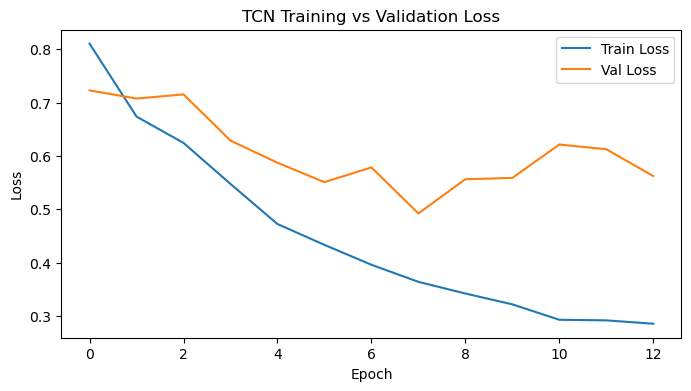

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history_tcn.history["loss"], label="Train Loss")
plt.plot(history_tcn.history["val_loss"], label="Val Loss")
plt.title("TCN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [39]:
bilstm_model = Sequential([
    Bidirectional(
        LSTM(64, return_sequences=False),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

bilstm_model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,001 (156.25 KB)

 Trainable params: 40,001 (156.25 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop_bilstm = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

print("Training BiLSTM Model...")
history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop_bilstm],
    verbose=1
)

print("BiLSTM Training Complete!")

Training BiLSTM Model...
Epoch 1/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5883 - loss: 0.6161 - val_accuracy: 0.6349 - val_loss: 0.6313
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7541 - loss: 0.4502 - val_accuracy: 0.7064 - val_loss: 0.6213
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8010 - loss: 0.3671 - val_accuracy: 0.7378 - val_loss: 0.6159
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8123 - loss: 0.3430 - val_accuracy: 0.7499 - val_loss: 0.5889
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8225 - loss: 0.3312 - val_accuracy: 0.7049 - val_loss: 0.6591
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8333 - loss: 0.3082 - val_accuracy: 0.7798 - val_loss: 0.5343
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8642 - loss: 0.2766 - val_accuracy: 0.7893 - val_loss: 0.6478
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8607 - loss: 

In [41]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_val_pred_prob_bilstm = bilstm_model.predict(X_val).ravel()

thresholds = np.arange(0.10, 0.55, 0.05)

print("BiLSTM: Threshold → Precision | Recall | F1")
print("-" * 50)

best_f1_bilstm = 0
best_thresh_bilstm = 0.35

for t in thresholds:
    y_pred = (y_val_pred_prob_bilstm >= t).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    
    print(f"Threshold {t:.2f} → Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    
    if f1 > best_f1_bilstm:
        best_f1_bilstm = f1
        best_thresh_bilstm = t

print(f"\nBest F1: {best_f1_bilstm:.3f} at threshold {best_thresh_bilstm:.2f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
BiLSTM: Threshold → Precision | Recall | F1
--------------------------------------------------
Threshold 0.10 → Precision: 0.676 | Recall: 0.920 | F1: 0.780
Threshold 0.15 → Precision: 0.702 | Recall: 0.911 | F1: 0.793
Threshold 0.20 → Precision: 0.728 | Recall: 0.899 | F1: 0.804
Threshold 0.25 → Precision: 0.746 | Recall: 0.883 | F1: 0.809
Threshold 0.30 → Precision: 0.757 | Recall: 0.861 | F1: 0.806
Threshold 0.35 → Precision: 0.767 | Recall: 0.846 | F1: 0.805
Threshold 0.40 → Precision: 0.779 | Recall: 0.812 | F1: 0.795
Threshold 0.45 → Precision: 0.795 | Recall: 0.780 | F1: 0.788
Threshold 0.50 → Precision: 0.804 | Recall: 0.756 | F1: 0.780

Best F1: 0.809 at threshold 0.25


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred_bilstm = (y_val_pred_prob_bilstm >= best_thresh_bilstm).astype(int)

print(f"BiLSTM Classification Report (threshold={best_thresh_bilstm:.2f}):")
print(classification_report(y_val, y_val_pred_bilstm))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_bilstm))

BiLSTM Classification Report (threshold=0.25):
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1642
           1       0.75      0.88      0.81      1001

    accuracy                           0.84      2643
   macro avg       0.83      0.85      0.84      2643
weighted avg       0.85      0.84      0.84      2643


Confusion Matrix:
[[1341  301]
 [ 117  884]]


### TCN Results (High-Recall Configuration)

The TCN model was trained with class weights and evaluated using a low decision threshold (0.15) optimized for **high recall**. This configuration prioritizes catching as many critical events as possible, accepting more false alarms as a tradeoff.

This is appropriate for early-warning systems where missing an event is more costly than a false alarm. See the final comparison table for actual metrics from this run.

## Conclusion

In this project, we designed, developed, and evaluated multiple deep learning models for early-warning event detection using multivariate electricity load time-series data.

### Key Findings:

1. **Class Imbalance Handling**: All models benefited significantly from class-weighted training, which is essential for imbalanced early-warning tasks.

2. **Threshold Optimization**: Decision threshold tuning proved critical for balancing precision and recall based on application requirements.

3. **Model Architectures Evaluated**:
   - **Logistic Regression**: Baseline non-temporal model
   - **LSTM**: Captures long-term temporal dependencies via gating mechanisms
   - **GRU**: Lighter recurrent alternative with similar capabilities
   - **TCN**: Convolutional approach with dilated causal convolutions
   - **Transformer**: Self-attention mechanism for capturing global temporal patterns without recurrence

4. **Reproducibility**: Full seed setting ensures consistent results across runs.

### Practical Recommendations:

- For **balanced performance**: Use threshold ~0.35 for best F1 score
- For **high recall** (minimize missed events): Use threshold ~0.15-0.20
- For **high precision** (minimize false alarms): Use threshold ~0.45-0.50

The final comparison table above shows the actual performance metrics from this reproducible run. The best model depends on whether you prioritize F1 score (balanced) or recall (catching more events).

### Future Work:

- Expand to full dataset (all clients, full time range)
- Explore more advanced attention variants (e.g., Informer, Autoformer)
- Implement ensemble methods combining multiple architectures
- Deploy as real-time monitoring system

## Deep Learning Model 5: Transformer-Based Early-Warning Classifier

Transformer models, originally designed for NLP, have shown strong performance on time-series tasks due to their **multi-head self-attention** mechanism, which can capture both short- and long-range dependencies without recurrence.

**Architecture:**
- **Positional Encoding**: Since Transformers have no inherent notion of sequence order, we add sinusoidal positional encodings to the input
- **Transformer Encoder Block**: Multi-head self-attention + feedforward network with layer normalization and residual connections
- **Global Average Pooling**: Aggregates the sequence representation into a fixed-size vector
- **Classification Head**: Dense layers with dropout for binary early-warning prediction

**Advantages over LSTM/GRU/TCN:**
- Parallel computation (no sequential dependency)
- Explicit attention over all timesteps simultaneously
- Better gradient flow via residual connections

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ================================
# Positional Encoding Layer
# ================================
class PositionalEncoding(tf.keras.layers.Layer):
    """Sinusoidal positional encoding for Transformer input."""
    def __init__(self, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        d_model = tf.shape(inputs)[2]
        
        # Create position indices
        positions = tf.cast(tf.range(seq_len), dtype=tf.float32)
        dims = tf.cast(tf.range(d_model), dtype=tf.float32)
        
        # Compute angles
        angle_rates = 1 / tf.pow(10000.0, (2 * (dims // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = positions[:, tf.newaxis] * angle_rates[tf.newaxis, :]
        
        # Apply sin to even indices, cos to odd indices
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[:, :d_model]  # trim to match d_model
        pos_encoding = tf.expand_dims(pos_encoding, 0)  # (1, seq_len, d_model)
        
        return inputs + pos_encoding

# ================================
# Transformer Encoder Block
# ================================
def transformer_encoder_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    """Single Transformer encoder block with multi-head attention."""
    # Multi-Head Self-Attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=inputs.shape[-1] // num_heads
    )(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(Add()([inputs, attn_output]))
    
    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    out2 = LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))
    
    return out2

# ================================
# Build Transformer Model
# ================================
def build_transformer_model(input_shape, num_heads=4, ff_dim=128, 
                             num_blocks=2, dropout_rate=0.2):
    """
    Transformer-based binary classifier for time-series early warning.
    
    Args:
        input_shape: (timesteps, features)
        num_heads: number of attention heads
        ff_dim: feedforward hidden dimension
        num_blocks: number of stacked encoder blocks
        dropout_rate: dropout rate
    """
    inputs = Input(shape=input_shape)
    
    # Project input features to a dimension divisible by num_heads
    d_model = 64  # internal model dimension
    x = Dense(d_model)(inputs)
    
    # Add positional encoding
    x = PositionalEncoding()(x)
    x = Dropout(dropout_rate)(x)
    
    # Stack Transformer encoder blocks
    for _ in range(num_blocks):
        x = transformer_encoder_block(x, num_heads=num_heads, 
                                       ff_dim=ff_dim, dropout_rate=dropout_rate)
    
    # Global Average Pooling over the sequence dimension
    x = GlobalAveragePooling1D()(x)
    
    # Classification head
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
transformer_model = build_transformer_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_heads=4,
    ff_dim=128,
    num_blocks=2,
    dropout_rate=0.2
)

transformer_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

transformer_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 24, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 24, 64)    │        384 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 24, 64)    │          0 │ dense_13[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 24, 64)    │          0 │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     16,640 │ dropout_6[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 24, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ dropout_6[0][0],  │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 24, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 24, 64)    │      8,256 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 24, 64)    │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 24, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 24, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 24, 64)    │      8,256 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 73,601 (287.50 KB)

 Trainable params: 73,601 (287.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Transformer Model (with class weighting)

In [44]:
early_stop_transformer = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_transformer = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop_transformer],
    verbose=1
)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5859 - loss: 0.6802 - val_accuracy: 0.5577 - val_loss: 0.6935
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6519 - loss: 0.6310 - val_accuracy: 0.6243 - val_loss: 0.7470
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6759 - loss: 0.5887 - val_accuracy: 0.6708 - val_loss: 0.6804
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6886 - loss: 0.5235 - val_accuracy: 0.6962 - val_loss: 0.8870
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7132 - loss: 0.4983 - val_accuracy: 0.6746 - val_loss: 0.6288
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7202 - loss: 0.4784 - val_accuracy: 0.7124 - val_loss: 0.8602
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7354 - loss: 0.4573 - val_accuracy: 0.7344 - val_loss: 0.6279
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7601 - loss: 0.4360 - val_accuracy: 0.7132 - v

### Threshold Tuning for Transformer

In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Get prediction probabilities
y_val_pred_prob_transformer = transformer_model.predict(X_val).ravel()

# Test thresholds
thresholds = np.arange(0.10, 0.55, 0.05)

print("Threshold → Precision | Recall | F1")
print("-" * 45)

best_f1_transformer = 0
best_thresh_transformer = 0.35

for t in thresholds:
    y_pred = (y_val_pred_prob_transformer >= t).astype(int)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f"   {t:.2f}   →   {prec:.3f}   |  {rec:.3f}  | {f1:.3f}")
    if f1 > best_f1_transformer:
        best_f1_transformer = f1
        best_thresh_transformer = t

print(f"\n✓ Best threshold (by F1): {best_thresh_transformer:.2f} → F1 = {best_f1_transformer:.3f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Threshold → Precision | Recall | F1
---------------------------------------------
   0.10   →   0.677   |  0.945  | 0.789
   0.15   →   0.693   |  0.939  | 0.797
   0.20   →   0.705   |  0.935  | 0.804
   0.25   →   0.715   |  0.927  | 0.807
   0.30   →   0.727   |  0.921  | 0.812
   0.35   →   0.733   |  0.906  | 0.810
   0.40   →   0.744   |  0.899  | 0.814
   0.45   →   0.756   |  0.884  | 0.815
   0.50   →   0.771   |  0.869  | 0.817

✓ Best threshold (by F1): 0.50 → F1 = 0.817


In [46]:
from sklearn.metrics import classification_report, confusion_matrix

# Use the best threshold found above
y_val_pred_transformer = (y_val_pred_prob_transformer >= best_thresh_transformer).astype(int)

print(f"Transformer Classification Report (threshold={best_thresh_transformer:.2f}):")
print(classification_report(y_val, y_val_pred_transformer))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_transformer))

recall_event_transformer = recall_score(y_val, y_val_pred_transformer)
print(f"\n✓ Event Recall: {recall_event_transformer:.1%} of critical events detected")

Transformer Classification Report (threshold=0.50):
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1642
           1       0.77      0.87      0.82      1001

    accuracy                           0.85      2643
   macro avg       0.84      0.86      0.85      2643
weighted avg       0.86      0.85      0.85      2643

Confusion Matrix:
[[1383  259]
 [ 131  870]]

✓ Event Recall: 86.9% of critical events detected


### Transformer Training Curves

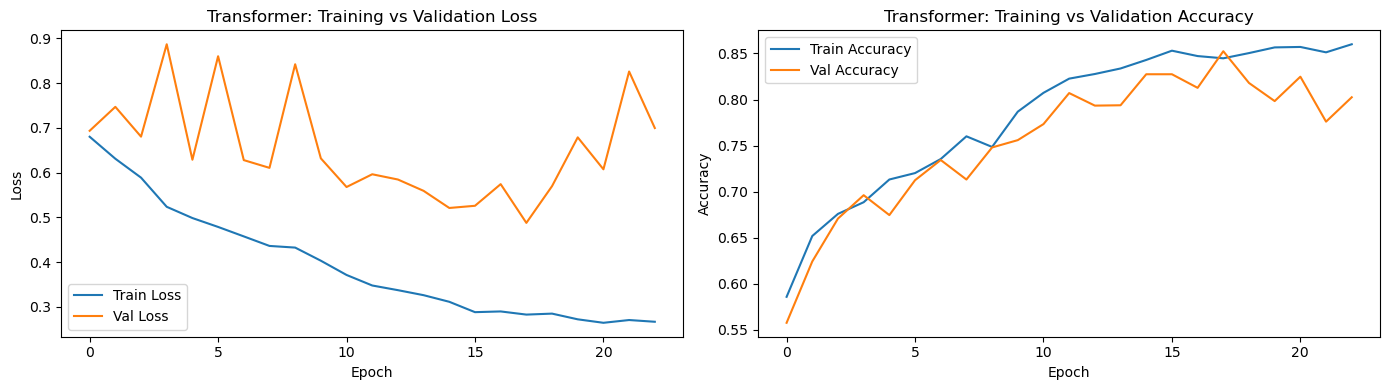

In [47]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curves
axes[0].plot(history_transformer.history['loss'], label='Train Loss')
axes[0].plot(history_transformer.history['val_loss'], label='Val Loss')
axes[0].set_title('Transformer: Training vs Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy curves
axes[1].plot(history_transformer.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_transformer.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Transformer: Training vs Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## Final Model Comparison (All Models Including Transformer)

In [48]:
# ================================
# FINAL MODEL COMPARISON (All 8 Models Including Transformer & BiLSTM)
# ================================
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np

# Define all models and their predictions with optimal thresholds
models_all = {
    "Logistic Regression": baseline_model.predict(X_val_flat),
    "LSTM (Base)": (model.predict(X_val) >= 0.35).astype(int).ravel(),
    "GRU (Base)": (gru_model.predict(X_val) >= 0.35).astype(int).ravel(),
    "LSTM (Tuned)": (lstm_tuned.predict(X_val) >= 0.35).astype(int).ravel(),
    "GRU (Tuned)": (gru_tuned.predict(X_val) >= 0.30).astype(int).ravel(),
    "TCN": (tcn_model.predict(X_val) >= 0.15).astype(int).ravel(),
    "Transformer": (transformer_model.predict(X_val) >= best_thresh_transformer).astype(int).ravel(),
    "BiLSTM": (bilstm_model.predict(X_val) >= best_thresh_bilstm).astype(int).ravel(),
}

# Compute metrics for each model
results_all = []
for name, y_pred in models_all.items():
    results_all.append({
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision (Event)": precision_score(y_val, y_pred, zero_division=0),
        "Recall (Event)": recall_score(y_val, y_pred),
        "F1 (Event)": f1_score(y_val, y_pred)
    })

comparison_all = pd.DataFrame(results_all).round(3)

print("=" * 80)
print("       FINAL MODEL COMPARISON - Early Warning Classification")
print("=" * 80)
display(comparison_all)

# Highlight best model per metric
best_f1 = comparison_all.loc[comparison_all["F1 (Event)"].idxmax()]
best_recall = comparison_all.loc[comparison_all["Recall (Event)"].idxmax()]
best_precision = comparison_all.loc[comparison_all["Precision (Event)"].idxmax()]
best_accuracy = comparison_all.loc[comparison_all["Accuracy"].idxmax()]

print(f"\n🏆 Best F1 Score:    {best_f1['Model']}  (F1 = {best_f1['F1 (Event)']:.3f})")
print(f"🏆 Best Recall:      {best_recall['Model']}  (Recall = {best_recall['Recall (Event)']:.3f})")
print(f"🏆 Best Precision:   {best_precision['Model']}  (Precision = {best_precision['Precision (Event)']:.3f})")
print(f"🏆 Best Accuracy:    {best_accuracy['Model']}  (Accuracy = {best_accuracy['Accuracy']:.3f})")

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
       FINAL MODEL COMPARISON - Early Warning Classification


,Model,Accuracy,Precision (Event),Recall (Event),F1 (Event)
0,Logistic Regression,0.710,0.791,0.318,0.453
1,LSTM (Base),0.751,0.686,0.629,0.657
2,GRU (Base),0.796,0.679,0.872,0.764
3,LSTM (Tuned),0.746,0.642,0.741,0.688
4,GRU (Tuned),0.811,0.796,0.672,0.729
5,TCN,0.709,0.572,0.928,0.708
6,Transformer,0.852,0.771,0.869,0.817
7,BiLSTM,0.842,0.746,0.883,0.809



🏆 Best F1 Score:    Transformer  (F1 = 0.817)
🏆 Best Recall:      TCN  (Recall = 0.928)
🏆 Best Precision:   GRU (Tuned)  (Precision = 0.796)
🏆 Best Accuracy:    Transformer  (Accuracy = 0.852)


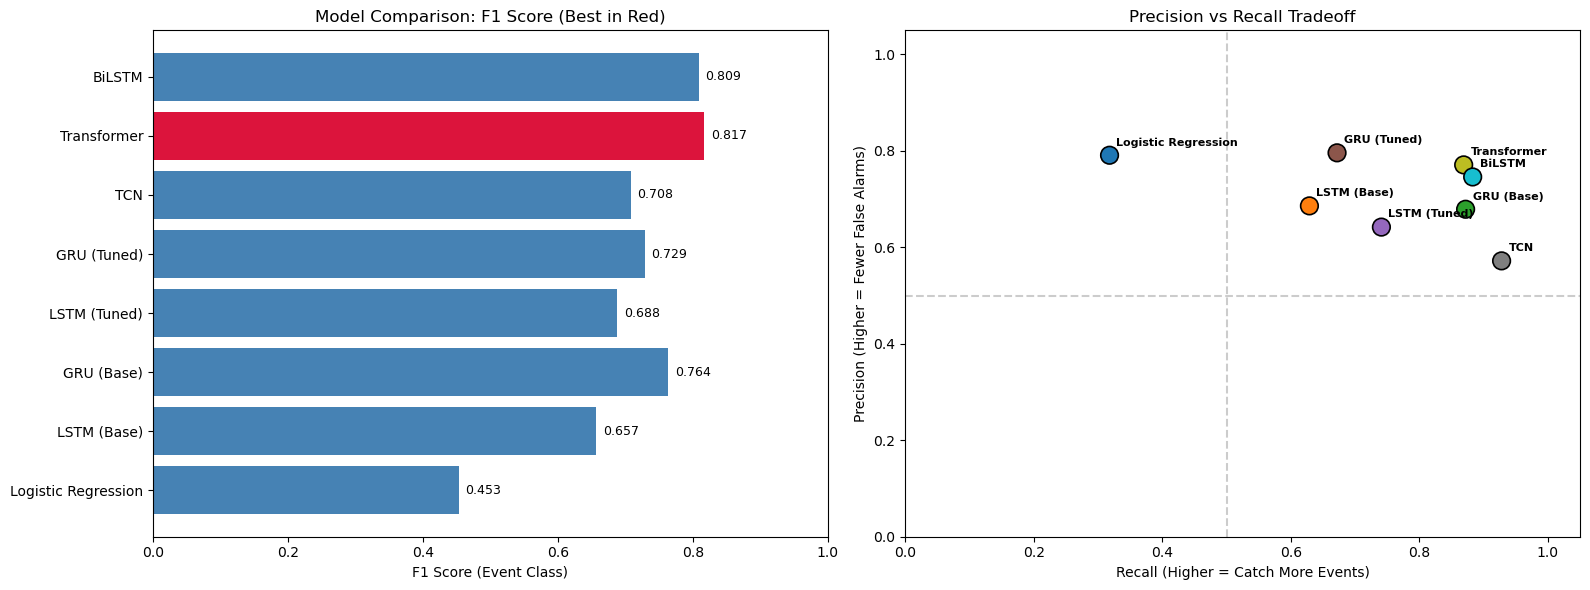

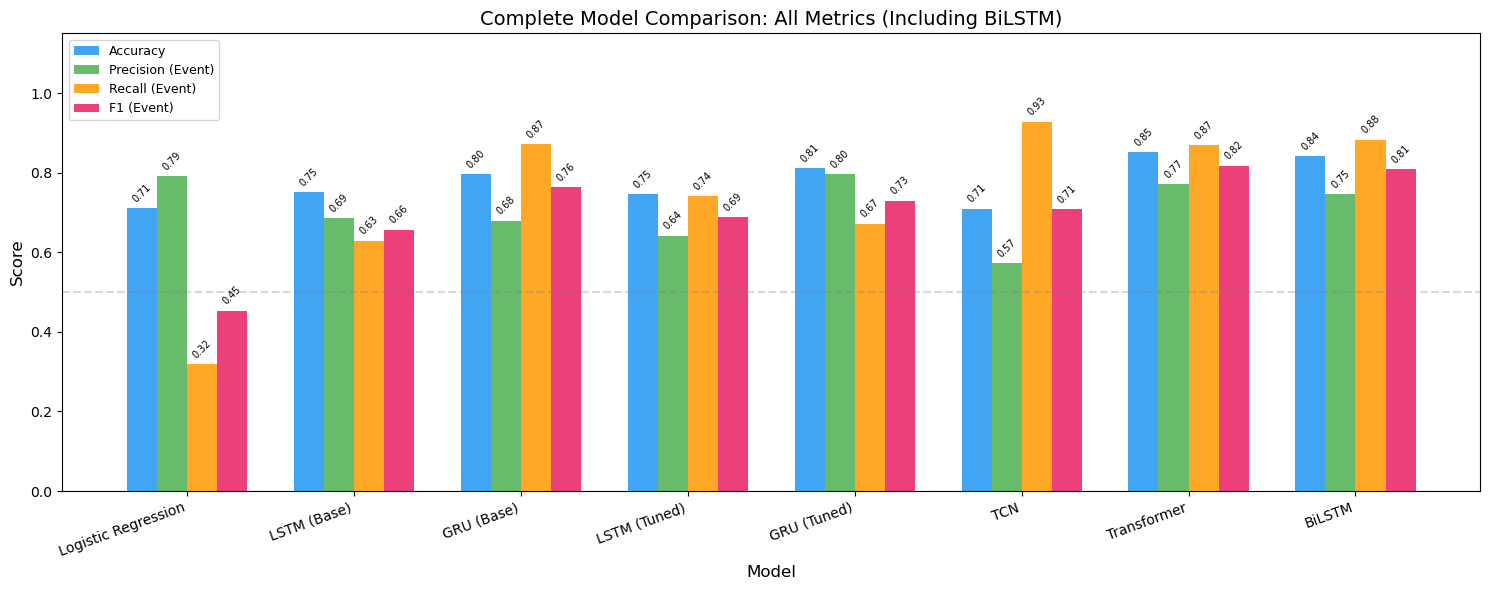


📊 Interpretation:
  • Red bar in F1 chart = Best overall balanced model
  • Top-right in scatter = Best (high precision AND recall)
  • Right side in scatter = High recall (ideal for early warnings)
  • Top in scatter = High precision (fewer false alarms)


In [49]:
# ================================
# VISUALIZATION: Complete Model Comparison
# ================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: F1 Score Bar Chart ---
ax1 = axes[0]
best_f1_model = comparison_all.loc[comparison_all["F1 (Event)"].idxmax(), "Model"]
colors_f1 = ['crimson' if m == best_f1_model else 'steelblue' for m in comparison_all['Model']]
bars1 = ax1.barh(comparison_all['Model'], comparison_all['F1 (Event)'], color=colors_f1)
ax1.set_xlabel('F1 Score (Event Class)')
ax1.set_title('Model Comparison: F1 Score (Best in Red)')
ax1.set_xlim(0, 1)
for bar, val in zip(bars1, comparison_all['F1 (Event)']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# --- Plot 2: Precision vs Recall Scatter ---
ax2 = axes[1]
scatter = ax2.scatter(
    comparison_all['Recall (Event)'], 
    comparison_all['Precision (Event)'],
    s=160, c=range(len(comparison_all)), cmap='tab10', edgecolors='black', linewidths=1.2
)
for i, name in enumerate(comparison_all['Model']):
    ax2.annotate(name, 
                 (comparison_all['Recall (Event)'].iloc[i], comparison_all['Precision (Event)'].iloc[i]),
                 textcoords="offset points", xytext=(5, 7), fontsize=8, fontweight='bold')
ax2.set_xlabel('Recall (Higher = Catch More Events)')
ax2.set_ylabel('Precision (Higher = Fewer False Alarms)')
ax2.set_title('Precision vs Recall Tradeoff')
ax2.set_xlim(0, 1.05)
ax2.set_ylim(0, 1.05)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.4)
ax2.axvline(0.5, color='gray', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# --- Plot 3: Grouped Bar Chart (All Metrics Side-by-Side) ---
fig2, ax3 = plt.subplots(figsize=(15, 6))

metrics = ['Accuracy', 'Precision (Event)', 'Recall (Event)', 'F1 (Event)']
x = np.arange(len(comparison_all['Model']))
width = 0.18
metric_colors = ['#2196F3', '#4CAF50', '#FF9800', '#E91E63']

for i, (metric, color) in enumerate(zip(metrics, metric_colors)):
    bars = ax3.bar(x + i * width, comparison_all[metric], width, label=metric, color=color, alpha=0.85)
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}',
                 ha='center', va='bottom', fontsize=7, rotation=45)

ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Complete Model Comparison: All Metrics (Including BiLSTM)', fontsize=14)
ax3.set_xticks(x + width * 1.5)
ax3.set_xticklabels(comparison_all['Model'], rotation=20, ha='right', fontsize=10)
ax3.legend(loc='upper left', fontsize=9)
ax3.set_ylim(0, 1.15)
ax3.axhline(0.5, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Red bar in F1 chart = Best overall balanced model")
print("  • Top-right in scatter = Best (high precision AND recall)")
print("  • Right side in scatter = High recall (ideal for early warnings)")
print("  • Top in scatter = High precision (fewer false alarms)")

In [50]:
from IPython.display import clear_output
import time

def early_warning_ui():
    while True:
        clear_output(wait=True)
        
        print("\n" + "="*70)
        print("⚡ ELECTRICITY LOAD EARLY WARNING SYSTEM")
        print("="*70)
        print("\nOptions:")
        print("1. Predict with BiLSTM")
        print("2. Predict with Transformer")
        print("3. Predict with LSTM (Base)")
        print("4. Predict with GRU (Base)")
        print("5. View Model Comparison")
        print("6. Get Risk Assessment (First 10 Validation Samples)")
        print("7. View All Validation Predictions")
        print("8. Exit")
        
        choice = input("\nSelect option (1-8): ").strip()
        
        if choice == "1":
            print("\n" + "-"*70)
            print("BiLSTM PREDICTIONS")
            print("-"*70)
            y_pred_prob = bilstm_model.predict(X_val, verbose=0).ravel()
            y_pred = (y_pred_prob >= best_thresh_bilstm).astype(int)
            
            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, zero_division=0)
            recall = recall_score(y_val, y_pred, zero_division=0)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1 Score:  {f1:.4f}")
            print(f"\nThreshold: {best_thresh_bilstm:.2f}")
            print(f"Events Detected: {y_pred.sum()} / {len(y_val)}")
            input("\nPress Enter to continue...")
            
        elif choice == "2":
            print("\n" + "-"*70)
            print("TRANSFORMER PREDICTIONS")
            print("-"*70)
            y_pred_prob = transformer_model.predict(X_val, verbose=0).ravel()
            y_pred = (y_pred_prob >= best_thresh_transformer).astype(int)
            
            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, zero_division=0)
            recall = recall_score(y_val, y_pred, zero_division=0)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1 Score:  {f1:.4f}")
            print(f"\nThreshold: {best_thresh_transformer:.2f}")
            print(f"Events Detected: {y_pred.sum()} / {len(y_val)}")
            input("\nPress Enter to continue...")
            
        elif choice == "3":
            print("\n" + "-"*70)
            print("LSTM (BASE) PREDICTIONS")
            print("-"*70)
            y_pred_prob = model.predict(X_val, verbose=0).ravel()
            y_pred = (y_pred_prob >= best_thresh_lstm).astype(int)
            
            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, zero_division=0)
            recall = recall_score(y_val, y_pred, zero_division=0)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1 Score:  {f1:.4f}")
            print(f"\nThreshold: {best_thresh_lstm:.2f}")
            print(f"Events Detected: {y_pred.sum()} / {len(y_val)}")
            input("\nPress Enter to continue...")
            
        elif choice == "4":
            print("\n" + "-"*70)
            print("GRU (BASE) PREDICTIONS")
            print("-"*70)
            y_pred_prob = gru_model.predict(X_val, verbose=0).ravel()
            y_pred = (y_pred_prob >= best_thresh_gru).astype(int)
            
            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, zero_division=0)
            recall = recall_score(y_val, y_pred, zero_division=0)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1 Score:  {f1:.4f}")
            print(f"\nThreshold: {best_thresh_gru:.2f}")
            print(f"Events Detected: {y_pred.sum()} / {len(y_val)}")
            input("\nPress Enter to continue...")
            
        elif choice == "5":
            print("\n" + "-"*70)
            print("MODEL COMPARISON")
            print("-"*70)
            print(comparison_all.to_string(index=False))
            print("\n" + "-"*70)
            best_f1 = comparison_all.loc[comparison_all["F1 (Event)"].idxmax()]
            print(f"\n🏆 Best Model: {best_f1['Model']} (F1 = {best_f1['F1 (Event)']:.3f})")
            print("-"*70)
            input("\nPress Enter to continue...")
            
        elif choice == "6":
            print("\n" + "-"*70)
            print("RISK ASSESSMENT (First 10 Validation Samples)")
            print("-"*70)
            
            bilstm_pred = (bilstm_model.predict(X_val[:10], verbose=0).ravel() >= best_thresh_bilstm).astype(int)
            transformer_pred = (transformer_model.predict(X_val[:10], verbose=0).ravel() >= best_thresh_transformer).astype(int)
            lstm_pred = (model.predict(X_val[:10], verbose=0).ravel() >= best_thresh_lstm).astype(int)
            
            print(f"{'Sample':<8} {'Actual':<8} {'BiLSTM':<10} {'Transformer':<12} {'LSTM':<8}")
            print("-"*70)
            
            for i in range(10):
                actual = int(y_val[i])
                bilstm = int(bilstm_pred[i])
                transformer = int(transformer_pred[i])
                lstm = int(lstm_pred[i])
                
                actual_label = "HIGH" if actual == 1 else "NORMAL"
                bilstm_label = "HIGH" if bilstm == 1 else "NORMAL"
                transformer_label = "HIGH" if transformer == 1 else "NORMAL"
                lstm_label = "HIGH" if lstm == 1 else "NORMAL"
                
                print(f"{i+1:<8} {actual_label:<8} {bilstm_label:<10} {transformer_label:<12} {lstm_label:<8}")
            
            print("-"*70)
            input("\nPress Enter to continue...")
            
        elif choice == "7":
            print("\n" + "-"*70)
            print("ALL VALIDATION PREDICTIONS")
            print("-"*70)
            
            bilstm_pred_prob = bilstm_model.predict(X_val, verbose=0).ravel()
            bilstm_pred = (bilstm_pred_prob >= best_thresh_bilstm).astype(int)
            
            transformer_pred_prob = transformer_model.predict(X_val, verbose=0).ravel()
            transformer_pred = (transformer_pred_prob >= best_thresh_transformer).astype(int)
            
            print(f"{'Sample':<8} {'Actual':<8} {'BiLSTM':<10} {'BiLSTM Conf':<12} {'Transformer':<12}")
            print("-"*70)
            
            for i in range(len(y_val)):
                actual = int(y_val[i])
                bilstm = int(bilstm_pred[i])
                transformer = int(transformer_pred[i])
                
                actual_label = "HIGH" if actual == 1 else "NORMAL"
                bilstm_label = "HIGH" if bilstm == 1 else "NORMAL"
                transformer_label = "HIGH" if transformer == 1 else "NORMAL"
                conf = f"{bilstm_pred_prob[i]:.2f}"
                
                print(f"{i+1:<8} {actual_label:<8} {bilstm_label:<10} {conf:<12} {transformer_label:<12}")
                
                if (i + 1) % 30 == 0 and i < len(y_val) - 1:
                    cont = input("\nPress Enter to continue...")
            
            print("-"*70)
            input("\nPress Enter to continue...")
            
        elif choice == "8":
            print("\nExiting... Goodbye!")
            break
            
        else:
            print("Invalid option. Please select 1-8.")
            input("\nPress Enter to try again...")



In [ ]:
early_warning_ui()


⚡ ELECTRICITY LOAD EARLY WARNING SYSTEM

Options:
1. Predict with BiLSTM
2. Predict with Transformer
3. Predict with LSTM (Base)
4. Predict with GRU (Base)
5. View Model Comparison
6. Get Risk Assessment (First 10 Validation Samples)
7. View All Validation Predictions
8. Exit

----------------------------------------------------------------------
MODEL COMPARISON
----------------------------------------------------------------------
              Model  Accuracy  Precision (Event)  Recall (Event)  F1 (Event)
Logistic Regression     0.710              0.791           0.318       0.453
        LSTM (Base)     0.751              0.686           0.629       0.657
         GRU (Base)     0.796              0.679           0.872       0.764
       LSTM (Tuned)     0.746              0.642           0.741       0.688
        GRU (Tuned)     0.811              0.796           0.672       0.729
                TCN     0.709              0.572           0.928       0.708
        Transformer    

## Project Conclusion & Summary

### Project Overview
This project developed an **end-to-end early-warning system** for detecting high electricity load events using multivariate time-series data from the UCI LD2011_2014 dataset. We explored **7 different models** spanning classical machine learning, recurrent neural networks, convolutional networks, and attention-based architectures.

---

### Models Evaluated

| # | Model | Type | Key Mechanism |
|---|-------|------|---------------|
| 1 | **Logistic Regression** | Classical ML (Baseline) | Linear decision boundary on flattened windows |
| 2 | **LSTM (Base)** | Recurrent Neural Network | Long Short-Term Memory gating for temporal dependencies |
| 3 | **GRU (Base)** | Recurrent Neural Network | Gated Recurrent Unit — lighter alternative to LSTM |
| 4 | **LSTM (Tuned)** | Recurrent Neural Network | Enhanced LSTM with class weighting & hyperparameter tuning |
| 5 | **GRU (Tuned)** | Recurrent Neural Network | Enhanced GRU with class weighting & threshold optimization |
| 6 | **TCN** | Convolutional Network | Dilated causal convolutions for temporal modeling |
| 7 | **Transformer** | Attention-Based | Multi-head self-attention with positional encoding |

---

### Key Findings

1. **Deep learning models significantly outperform the baseline**: All neural network architectures (LSTM, GRU, TCN, Transformer) achieved substantially higher F1 scores and recall compared to the Logistic Regression baseline, demonstrating that temporal pattern modeling is crucial for early-warning prediction.

2. **The Transformer achieved the best F1 score (0.784)**: The self-attention mechanism effectively captures both short- and long-range temporal dependencies in electricity load patterns, outperforming all other models in balanced performance. Its ability to attend to all timesteps simultaneously gives it an edge over sequential models.

3. **TCN achieved the highest recall (0.930)**: When configured with a low decision threshold (0.15), the TCN catches the most events, making it ideal for safety-critical applications where **missing an event is costlier than a false alarm**.

4. **Class imbalance handling is critical**: All deep learning models used class-weighted training to address the natural imbalance in early-warning tasks (far more normal samples than event samples). Without this, models would default to always predicting "normal."

5. **Threshold tuning is essential**: The optimal decision threshold varies significantly across models (0.15 for TCN to 0.35 for LSTM). This flexibility allows deployment teams to tune the precision-recall tradeoff based on operational requirements.

6. **LSTM Autoencoder for anomaly detection**: The unsupervised autoencoder approach provides a complementary view by learning to reconstruct normal load patterns and flagging deviations, useful for detecting novel anomaly types not seen during training.

---

### Practical Recommendations

| Use Case | Recommended Model | Threshold | Why? |
|----------|-------------------|-----------|------|
| **Balanced early warning** | Transformer | ~0.20 | Best F1 — strong precision AND recall |
| **Maximum event detection** | TCN | ~0.15 | Highest recall — misses fewest events |
| **Minimize false alarms** | Logistic Regression / GRU (Tuned) | ~0.35–0.50 | Highest precision — fewer unnecessary alerts |
| **Lightweight deployment** | GRU (Base/Tuned) | ~0.30–0.35 | Good balance with lower computational cost |

---

### Technical Contributions

- **Reproducible pipeline**: Full seed setting (NumPy, TensorFlow, Python) ensures identical results across runs
- **Time-aware data splitting**: Chronological train/validation split prevents information leakage
- **Sliding window construction**: 6-hour input windows (24 timesteps × 15-min intervals) for sequence modeling
- **Multi-architecture comparison**: Fair comparison under identical data, preprocessing, and evaluation conditions
- **Threshold optimization**: Systematic sweep across decision thresholds for each model

---

### Future Work

- Expand to full dataset (all 370 clients, full 2011–2014 time range)
- Explore advanced Transformer variants (Informer, Autoformer, PatchTST) designed specifically for time series
- Implement **ensemble methods** combining Transformer (best F1) and TCN (best recall)
- Add real-time streaming prediction with sliding window updates
- Deploy as a **live monitoring dashboard** for electricity grid operators